# Определение возраста покупателей

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Ход исследования**
1. Проведение исследовательского анализа набора фотографий.
2. Подготовка данных к обучению.
3. Обучение нейронной сети и рассчет её качества.

In [22]:
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовыательский анализ данных.
### Загрузка данных

In [28]:
#labels = pd.read_csv('/datasets/faces/labels.csv')
labels = pd.read_csv('E:/Data/appa-real-release/gt_train.csv')
display(labels)
labels = labels.drop(['apparent_age', 'worker_age', 'worker_gender'], axis=1)
labels = labels.drop_duplicates()
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    #directory='/datasets/faces/final_files/',
    directory='E:/Data/appa-real-release/train/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

,file_name,real_age,apparent_age,worker_age,worker_gender
0,000000.jpg,4,5,36,male
1,000000.jpg,4,4,38,female
2,000000.jpg,4,7,52,female
3,000000.jpg,4,5,50,male
4,000000.jpg,4,4,52,female
...,...,...,...,...,...
133930,004112.jpg,20,17,-1,NaN
133931,004112.jpg,20,20,26,NaN
133932,004112.jpg,20,22,31,NaN
133933,004112.jpg,20,19,19,NaN


Found 4113 validated image filenames.


### Изучение данных
#### Размерность

In [29]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4113 entries, 0 to 133867
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  4113 non-null   object
 1   real_age   4113 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 96.4+ KB


In [30]:
labels.shape

(4113, 2)

#### Статистика

In [31]:
labels['real_age'].describe()

count    4113.000000
mean       30.476052
std        16.312428
min         1.000000
25%        19.000000
50%        28.000000
75%        40.000000
max       100.000000
Name: real_age, dtype: float64

#### Распределение

In [32]:
fig = px.histogram(labels['real_age'], x="real_age", nbins=100, title='Histogram of age distribution')
fig.show()

#### Демонстрация

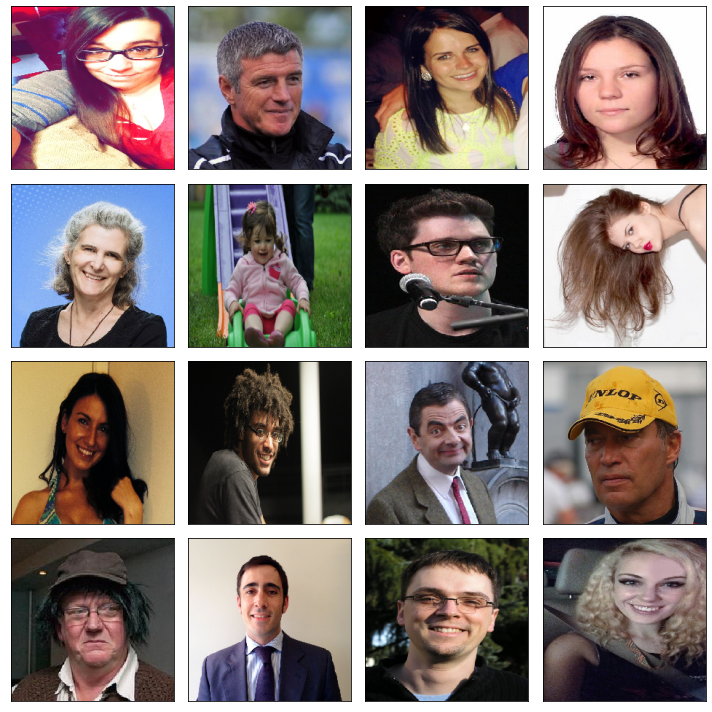

In [33]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод
1. Выборка для обучения составляет 7591 фото, это не много, в оригинальном наборе обучающая выборка 133935 фото.
2. В целом присутствую все возрастные категории: младенцы (< 5 лет), подростки (6-17), молодые (18-44), средние (45-60)
, пожилые (61-75), старые (> 75).
3. Наиболее частый возраст от 16 до 40 лет.
4. В выборке есть долгожители (> 90) и новорожденные (1 год).
5. В среднем изображение лица занимает 25% всего изображения. Алгоритму придется научиться отсекать не нужный фон.
6. Изображения в цветном и черно-белом изображении.
7. Присутствуют элементы усложнения: профиль, затенение, посторонние предметы, закрывающие часть лица (головной убор,
очки, жевательная резинка, косынка, микрофон).

## Обучение нейронной сетки
### Модель
``` python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```
### Вывод решения
```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 71s - loss: 218.0052 - mae: 10.6077 - val_loss: 512.1641 - val_mae: 17.4450
Epoch 2/10
356/356 - 59s - loss: 83.5754 - mae: 6.9877 - val_loss: 125.4853 - val_mae: 8.4232
Epoch 3/10
356/356 - 60s - loss: 57.4054 - mae: 5.7752 - val_loss: 126.4585 - val_mae: 8.8181
Epoch 4/10
356/356 - 59s - loss: 39.3999 - mae: 4.8226 - val_loss: 78.2037 - val_mae: 6.7492
Epoch 5/10
356/356 - 59s - loss: 34.3479 - mae: 4.4331 - val_loss: 77.9808 - val_mae: 6.7502
Epoch 6/10
356/356 - 59s - loss: 26.6193 - mae: 3.9049 - val_loss: 67.5945 - val_mae: 6.1014
Epoch 7/10
356/356 - 60s - loss: 19.0316 - mae: 3.3299 - val_loss: 95.7380 - val_mae: 7.5585
Epoch 8/10
356/356 - 59s - loss: 17.0744 - mae: 3.1373 - val_loss: 67.6779 - val_mae: 6.0915
Epoch 9/10
356/356 - 59s - loss: 14.0369 - mae: 2.8494 - val_loss: 66.6722 - val_mae: 6.1786
Epoch 10/10
356/356 - 59s - loss: 12.2241 - mae: 2.6679 - val_loss: 62.7556 - val_mae: 5.9548

119/119 - 11s - loss: 62.7556 - mae: 5.9548
Test MAE: 5.9548
```

## Общий вывод
- В ходе исследования нам удалось обучить модель нейронной сети с удовлетворительным качеством обучения.
- Оценочная метрика MAE на тестовой выборке равна **mae=5.9549**, это хороший результат.
- Архитектура нейронной сетки ResNet50 показала хорошую скорость и качество обучения.
- Для улучшения качества обучения мы использовали один вид аугментации - **горизонатльное скольжение**, алгоритм оптимизации **Adam**, с параметром скорость обучения lr=0.0001.
- Модель использует функцию потерь для задачи регрессии - **mean_squared_error**.